# 🎶 Music Genre Embedding & Recommendation Pipeline

This notebook contains the **fully‑working, end‑to‑end code** we discussed. Run each section in order or cherry‑pick parts you need.

## Contents
1. Data preparation & class balancing
2. SpecAugment‑based data augmentation (fixed version)
3. Supervised CNN classifier baseline


> **Prerequisites**  
> • Dataset folders defined in the *Paths* cell  
> • Install deps once:  
> `pip install librosa tqdm faiss-cpu umap-learn scikit-learn matplotlib seaborn tensorflow==2.16.1`


In [ ]:
# Mount Google Drive for accessing data stored in Google Drive (for Colab environments)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 1️⃣ Imports & global paths  (←— EDIT PATHS IF NEEDED)
import os, random, itertools, json, math, shutil, pickle
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# Audio processing libraries
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import pairwise, average_precision_score
from sklearn.preprocessing import LabelBinarizer

# Deep learning framework
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Set seeds for reproducibility across all random operations
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# === DATASET LAYOUT ===
# Paths for FMA (Free Music Archive) dataset metadata and audio files
META_DIR  = '/content/drive/MyDrive/fma_metadata'   # Directory containing metadata CSV files
AUDIO_DIR = '/content/drive/MyDrive/fma_medium'     # Directory containing audio (MP3) files
WORK_DIR  = '/content/drive/MyDrive/ai-final'       # Working directory for storing intermediate files
Path(WORK_DIR).mkdir(parents=True, exist_ok=True)   # Create working directory if it doesn't exist

print('✔️  Paths set – edit if your dataset lives elsewhere')


✔️  Paths set – edit if your dataset lives elsewhere


In [ ]:
# 2️⃣ Little helpers
import re

def id_to_path(track_id: int, audio_dir: str = AUDIO_DIR) -> str:
    """
    Convert a track ID to its file system path following the FMA dataset organization.
    
    Args:
        track_id (int): The numeric ID of the track
        audio_dir (str): Base directory where audio files are stored
        
    Returns:
        str: Full path to the MP3 file
    """
    sid = f"{track_id:06d}"  # Zero-pad track ID to 6 digits
    return os.path.join(audio_dir, sid[:3], f"{sid}.mp3")  # Group in subdirectories by first 3 digits

def exists_mp3(track_id: int) -> bool:
    """
    Check if MP3 file exists for the given track ID.
    
    Args:
        track_id (int): The numeric ID of the track
        
    Returns:
        bool: True if file exists, False otherwise
    """
    return Path(id_to_path(track_id)).exists()

def set_mpl_style():
    """Set consistent matplotlib style for all visualizations."""
    plt.style.use('default')
    plt.rcParams['figure.dpi'] = 110  # Higher DPI for better quality plots

set_mpl_style()  # Apply the style settings


## 3. Data preparation & class balancing

This section handles the preparation of a balanced dataset for music genre classification. We'll:
1. Select specific music genres of interest
2. Ensure we have a balanced number of examples per genre (2000 per class)
3. Filter out tracks that don't have MP3 files available

In [ ]:
from pathlib import Path

# Path to store the balanced dataset
BALANCED_PATH = Path(WORK_DIR) / 'balanced_filtered_tracks.csv'

# Target number of samples per genre class 
TARGET_SIZE = 2000

# Check if balanced dataset already exists to avoid reprocessing
if BALANCED_PATH.exists():
    print(f'⚡️ Skipping: {BALANCED_PATH} already exists!')
    balanced = pd.read_csv(BALANCED_PATH, index_col=0)
    print('Loaded existing balanced DataFrame.')
    print('Balanced dataset shape:', balanced.shape)
    print(balanced['track.genre_top'].value_counts())
else:
    # Define the genres we want to include in our dataset
    selected_genres = [
        'Rock', 'Electronic', 'Experimental', 'Hip-Hop',
        'Folk', 'Instrumental', 'Pop', 'International'
    ]

    # Load and process original tracks metadata
    tracks = pd.read_csv(Path(META_DIR) / 'tracks.csv', header=[0, 1], index_col=0)
    tracks.columns = ['.'.join(col).strip() for col in tracks.columns.values]  # Flatten multi-level columns
    tracks = tracks.dropna(subset=['track.genre_top'])  # Remove entries without genre info
    tracks = tracks[tracks['track.genre_top'].isin(selected_genres)]  # Keep only selected genres
    
    # Check if MP3 files actually exist for each track
    mask = tracks.index.to_series().apply(exists_mp3)
    tracks = tracks[mask]

    print('After initial filter:', len(tracks))

    # Balance the dataset by sampling equal numbers from each genre
    balanced_rows = []

    for g, g_df in tracks.groupby('track.genre_top'):
        if len(g_df) >= TARGET_SIZE:
            # If we have more than enough samples, randomly select TARGET_SIZE
            balanced_rows.append(g_df.sample(n=TARGET_SIZE, random_state=SEED))
        else:
            # For underrepresented genres, keep all samples (will be augmented later)
            balanced_rows.append(g_df)

    # Combine all balanced genre groups and sort by index
    balanced = pd.concat(balanced_rows).sort_index()
    balanced.to_csv(BALANCED_PATH)  # Save balanced dataset for future use
    print('Balanced dataset shape:', balanced.shape)
    print(balanced['track.genre_top'].value_counts())


⚡️ Skipping: /content/drive/MyDrive/ai-final/balanced_filtered_tracks.csv already exists!
Loaded existing balanced DataFrame.
Balanced dataset shape: (13073, 52)
track.genre_top
Hip-Hop          2000
Experimental     2000
Electronic       2000
Rock             2000
Folk             1519
Instrumental     1350
Pop              1186
International    1018
Name: count, dtype: int64


## 4. SpecAugment – fixed implementation

SpecAugment is a data augmentation technique originally developed for speech recognition, but works well for music spectrograms too. It applies:
1. Frequency masking: zeros out random frequency bands
2. Time masking: zeros out random time segments

This creates variations of the same audio sample to improve model generalization.

In [ ]:
import numpy as np

def spec_augment(mel, max_f=15, max_t=25):
    """
    Simple frequency & time masking for spectrogram augmentation (in‑place copy).
    
    Args:
        mel (np.ndarray): Input mel spectrogram
        max_f (int): Maximum width of frequency mask
        max_t (int): Maximum width of time mask
        
    Returns:
        np.ndarray: Augmented spectrogram with masked regions
    """
    mel = mel.copy()  # Create a copy to avoid modifying the original
    
    # Frequency mask: zero out a random band of frequencies
    f = np.random.randint(0, max_f)  # Random width of frequency mask
    f0 = np.random.randint(0, max(1, mel.shape[0] - f))  # Random starting point
    mel[f0:f0+f, :] = 0
    
    # Time mask: zero out a random segment of time
    t = np.random.randint(0, max_t)  # Random width of time mask
    t0 = np.random.randint(0, max(1, mel.shape[1] - t))  # Random starting point
    mel[:, t0:t0+t] = 0
    
    return mel


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# Directory to store augmented mel spectrograms
AUG_DIR = Path(WORK_DIR) / 'aug_mels'
AUG_DIR.mkdir(parents=True, exist_ok=True)
AUG_META_PATH = Path(WORK_DIR) / "aug_meta.csv"

# Identify genres that need augmentation (underrepresented classes)
minority_genres = ['Folk', 'Instrumental', 'Pop', 'International']

# Audio processing parameters
SAMPLE_RATE = 22050
N_MELS = 128
aug_meta = []

# Process each minority genre
for g in minority_genres:
    g_df = balanced[balanced['track.genre_top'] == g]
    needed = TARGET_SIZE - len(g_df)
    
    if needed <= 0:
        print(f'🔁 {g}: Augmentation not needed (already {len(g_df)})')
        continue
        
    print(f'🔁 Augmenting {g}: need {needed}')
    
    # Generate the needed number of augmented samples
    for _ in tqdm(range(needed)):
        # Randomly select a track from this genre as base for augmentation
        row = g_df.sample(n=1, random_state=np.random.randint(1e9)).iloc[0]
        track_id = row.name
        out_path = AUG_DIR / f"{track_id:06d}_aug.npy"

        # Skip if this augmented file already exists
        if out_path.exists():
            continue

        try:
            # Load audio and convert to mel spectrogram
            y, sr = librosa.load(id_to_path(track_id), sr=SAMPLE_RATE, mono=True)
            mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=N_MELS)
            logmel = librosa.power_to_db(mel, ref=np.max)  # Convert to log scale
            
            # Apply SpecAugment for data augmentation
            logmel = spec_augment(logmel)
            
            # Normalize to [0,1] range
            logmel = (logmel - logmel.min()) / (logmel.max() - logmel.min() + 1e-6)

            # Save as numpy file
            np.save(out_path, logmel.astype(np.float32))

            # Record metadata for this augmented sample
            aug_meta.append({
                'track_id': track_id,
                'genre_top': g,
                'augmented': True,
                'mel_path': str(out_path)
            })
        except Exception as e:
            print('⚠️', e)

# Update augmentation metadata file
if AUG_META_PATH.exists():
    # If metadata exists, append new augmentations
    aug_df_old = pd.read_csv(AUG_META_PATH, index_col=0)
    if len(aug_meta) > 0:
        aug_df_new = pd.DataFrame(aug_meta).set_index('track_id')
        aug_df = pd.concat([aug_df_old, aug_df_new]).drop_duplicates(keep='first')
    else:
        aug_df = aug_df_old
else:
    # Create new metadata file
    if len(aug_meta) > 0:
        aug_df = pd.DataFrame(aug_meta).set_index('track_id')
    else:
        aug_df = pd.DataFrame(columns=["genre_top", "augmented", "mel_path"])

# Save augmentation metadata
aug_df.to_csv(AUG_META_PATH)
print('Augmented rows (total):', len(aug_df))

# Create final combined metadata with both original and augmented samples
balanced['augmented'] = False  # Mark original samples as not augmented
balanced['mel_path']  = balanced.index.map(lambda tid: None)  # No pre-computed mel path for originals

# Combine original and augmented metadata
final_meta = pd.concat([balanced, aug_df])
final_meta.to_csv(Path(WORK_DIR) / 'final_balanced_tracks.csv')
print('✅ Final meta saved – total rows:', len(final_meta))


🔁 Augmenting Folk: need 481


 56%|█████▌    | 270/481 [00:56<00:17, 12.00it/s]/tmp/ipython-input-6-3218163047.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(id_to_path(track_id), sr=SAMPLE_RATE, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|██████    | 289/481 [00:57<00:13, 14.22it/s]

⚠️ 


100%|██████████| 481/481 [01:03<00:00,  7.54it/s]


🔁 Augmenting Instrumental: need 650


  8%|▊         | 55/650 [00:12<01:42,  5.79it/s]/tmp/ipython-input-6-3218163047.py:32: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(id_to_path(track_id), sr=SAMPLE_RATE, mono=True)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 10%|▉         | 62/650 [00:13<01:44,  5.63it/s]

⚠️ 


100%|██████████| 650/650 [00:56<00:00, 11.56it/s]


🔁 Augmenting Pop: need 814


100%|██████████| 814/814 [00:43<00:00, 18.71it/s]


🔁 Augmenting International: need 982


100%|██████████| 982/982 [01:25<00:00, 11.49it/s]


Augmented rows (total): 3316
✅ Final meta saved – total rows: 16389


## 5. Convert all mel‑spectrograms to `.npy` arrays

In this section, we:
1. Convert audio samples to mel spectrograms
2. For augmented samples, load their pre-computed spectrograms
3. Ensure all spectrograms are normalized and have consistent dimensions
4. Save the processed data as NumPy arrays for efficient training

In [ ]:
from pathlib import Path
import numpy as np
from tqdm import tqdm

# Directory to store numpy arrays
NPY_DIR = Path(WORK_DIR) / 'npy_data'
NPY_DIR.mkdir(exist_ok=True)

# Define paths for feature array (X) and label array (y)
X_PATH = NPY_DIR / 'X_all-old.npy'
Y_PATH = NPY_DIR / 'y_all-old.npy'

# Check if arrays already exist to avoid reprocessing
if X_PATH.exists() and Y_PATH.exists():
    print(f"⚡️ Skipping: {X_PATH.name} and {Y_PATH.name} already exist!")
    X = np.load(X_PATH)
    y = np.load(Y_PATH)
    print('Loaded existing arrays:', X.shape, y.shape)
else:
    X_list, y_list = [], []

    # Ensure we have valid genre information
    final_meta = final_meta.dropna(subset=['track.genre_top'])

    # Create mapping from genre names to numeric indices
    genre_names = sorted(final_meta['track.genre_top'].unique())
    genre_to_idx = {g: i for i, g in enumerate(genre_names)}

    def load_or_compute_mel(tid):
        """
        Load pre-computed mel spectrogram if available (augmented samples),
        otherwise compute it on the fly (original samples).
        
        Args:
            tid: Track ID
            
        Returns:
            np.ndarray: Mel spectrogram 
        """
        row = final_meta.loc[tid]
        if 'augmented' in row and row['augmented']:
            return np.load(row['mel_path'])
        
        # For original samples, compute mel spectrogram
        y, sr = librosa.load(id_to_path(tid), sr=SAMPLE_RATE, mono=True)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048,
                                             hop_length=512, n_mels=N_MELS)
        logmel = librosa.power_to_db(mel, ref=np.max)
        logmel = (logmel - logmel.min()) / (logmel.max() - logmel.min() + 1e-6)
        return logmel

    skipped = 0

    # Process each track
    for tid in tqdm(final_meta.index, desc='Mel→NPY'):
        try:
            # Get or compute mel spectrogram
            mel = load_or_compute_mel(tid)
            
            # Ensure consistent time dimension by padding/trimming
            mel = librosa.util.fix_length(mel, size=128, axis=1)
            
            # Add channel dimension for CNN input (N, H, W, C)
            X_list.append(mel[..., np.newaxis])
            
            # Get genre index for this track
            y_idx = genre_to_idx[final_meta.loc[tid]['track.genre_top']]
            y_list.append(y_idx)
        except Exception as e:
            print(f"⚠️ {tid}: {e} (skipped)")
            skipped += 1
            continue

    # Convert lists to numpy arrays
    X = np.stack(X_list).astype(np.float32)
    y = np.array(y_list)
    
    # Save arrays for future use
    np.save(X_PATH, X)
    np.save(Y_PATH, y)

    print('✅ Saved:', X.shape, y.shape)
    print(f"Toplam atlanan sample: {skipped}")


⚡️ Skipping: X_all-old.npy and y_all-old.npy already exist!
Loaded existing arrays: (13065, 128, 128, 1) (13065,)


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# === Paths ===
WORK_DIR = Path('/content/drive/MyDrive/ai-final')
NPY_DIR = WORK_DIR / 'npy_data'
NPY_DIR.mkdir(parents=True, exist_ok=True)

# Load the original data arrays
X_ORIG = np.load(NPY_DIR / 'X_all-old.npy')
y_ORIG = np.load(NPY_DIR / 'y_all-old.npy')

# === Load metadata ===
meta = pd.read_csv(WORK_DIR / 'final_balanced_tracks.csv')

# Inspect metadata structure and distribution
print(meta.shape)
print(meta.head())
print(meta['track.genre_top'].value_counts())

# Select augmented samples from metadata
aug_meta = meta[meta['augmented'] == True].copy()

# Verify mel spectrogram files exist for augmented samples
aug_meta['mel_exists'] = aug_meta['mel_path'].apply(lambda p: Path(p).exists() if isinstance(p, str) else False)
aug_meta = aug_meta[aug_meta['mel_exists']]
print(aug_meta)  # Show valid augmented samples


/tmp/ipython-input-8-193614635.py:15: DtypeWarning: Columns (0,2,3,4,7,9,10,11,13,14,15,16,17,19,23,25,26,27,28,29,30,31,32,35,36,37,40,41,42,43,45,46,48,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(WORK_DIR / 'final_balanced_tracks.csv')


(16389, 56)
  Unnamed: 0  album.comments   album.date_created  album.date_released  \
0          2             0.0  2008-11-26 01:44:45  2009-01-05 00:00:00   
1          5             0.0  2008-11-26 01:44:45  2009-01-05 00:00:00   
2         10             0.0  2008-11-26 01:45:08  2008-02-06 00:00:00   
3        134             0.0  2008-11-26 01:44:45  2009-01-05 00:00:00   
4        139             0.0  2008-11-26 01:49:57  2009-01-16 00:00:00   

  album.engineer  album.favorites  album.id  \
0            NaN              4.0       1.0   
1            NaN              4.0       1.0   
2            NaN              4.0       6.0   
3            NaN              4.0       1.0   
4            NaN              1.0      60.0   

                                   album.information  album.listens  \
0                                            <p></p>         6073.0   
1                                            <p></p>         6073.0   
2                                              

In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import librosa
from tqdm import tqdm

# === Paths ===
WORK_DIR = Path('/content/drive/MyDrive/ai-final')
NPY_DIR = WORK_DIR / 'npy_data'
NPY_DIR.mkdir(parents=True, exist_ok=True)

# === Metadata ===
# Load combined metadata and filter to valid augmented samples
meta = pd.read_csv(WORK_DIR / 'final_balanced_tracks.csv')
aug_meta = meta[(meta['augmented'] == True) & (meta['mel_path'].notna())].copy()
aug_meta['mel_exists'] = aug_meta['mel_path'].apply(lambda p: Path(p).exists())
aug_meta = aug_meta[aug_meta['mel_exists']]

# === Create genre-to-index mapping ===
genre_to_idx = {genre: i for i, genre in enumerate(sorted(meta['track.genre_top'].dropna().unique()))}

# === Load and process augmented mel spectrograms ===
X_aug, y_aug, skipped_paths = [], [], []
FIXED_LENGTH = 128  # Target time dimension for all spectrograms

# Process each augmented sample
for _, row in tqdm(aug_meta.iterrows(), total=len(aug_meta), desc='🔁 Fixing length & loading'):
    try:
        # Load pre-computed mel spectrogram
        mel = np.load(row['mel_path'])  # (128, N) shape
        
        # Ensure consistent time dimension (pad/trim)
        mel_fixed = librosa.util.fix_length(mel, size=FIXED_LENGTH, axis=1)

        # Verify expected shape
        if mel_fixed.shape != (128, 128):
            raise ValueError(f"Unexpected shape after fix: {mel_fixed.shape}")

        # Add to data lists
        X_aug.append(mel_fixed)
        y_aug.append(genre_to_idx[row['genre_top']])

    except Exception as e:
        skipped_paths.append((row['mel_path'], str(e)))

# === Convert to numpy arrays and save ===
if len(X_aug) > 0:
    # Add channel dimension for CNN input
    X_aug = np.stack(X_aug).astype(np.float32)[..., np.newaxis]  # (N, 128, 128, 1)
    y_aug = np.array(y_aug)

    # Save separate arrays for augmented samples
    np.save(NPY_DIR / 'X_aug_fixed.npy', X_aug)
    np.save(NPY_DIR / 'y_aug_fixed.npy', y_aug)

    print(f"✅ Yüklendi ve kaydedildi: {X_aug.shape}, {y_aug.shape}")
else:
    print("❌ Hâlâ geçerli örnek yok!")

# === Log errors ===
if skipped_paths:
    print(f"⚠️ {len(skipped_paths)} dosya atlandı (örnek):")
    for path, err in skipped_paths[:5]:
        print(f"{path} -> {err}")


/tmp/ipython-input-9-4282932126.py:13: DtypeWarning: Columns (0,2,3,4,7,9,10,11,13,14,15,16,17,19,23,25,26,27,28,29,30,31,32,35,36,37,40,41,42,43,45,46,48,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv(WORK_DIR / 'final_balanced_tracks.csv')
🔁 Fixing length & loading: 100%|██████████| 3316/3316 [29:47<00:00,  1.86it/s]


✅ Yüklendi ve kaydedildi: (3316, 128, 128, 1), (3316,)


In [ ]:
# Load original data arrays 
X_orig = np.load(NPY_DIR / 'X_all-old.npy')
y_orig = np.load(NPY_DIR / 'y_all-old.npy')

# Load augmented data arrays
X_aug = np.load(NPY_DIR / 'X_aug_fixed.npy')
y_aug = np.load(NPY_DIR / 'y_aug_fixed.npy')

# Combine original and augmented data
X_all = np.concatenate([X_orig, X_aug], axis=0)
y_all = np.concatenate([y_orig, y_aug], axis=0)

# Save the final combined dataset
np.save(NPY_DIR / 'X_all.npy', X_all)
np.save(NPY_DIR / 'y_all.npy', y_all)

print(f"🎉 Yeni veri seti kaydedildi: {X_all.shape}, {y_all.shape}")


🎉 Yeni veri seti kaydedildi: (16381, 128, 128, 1), (16381,)


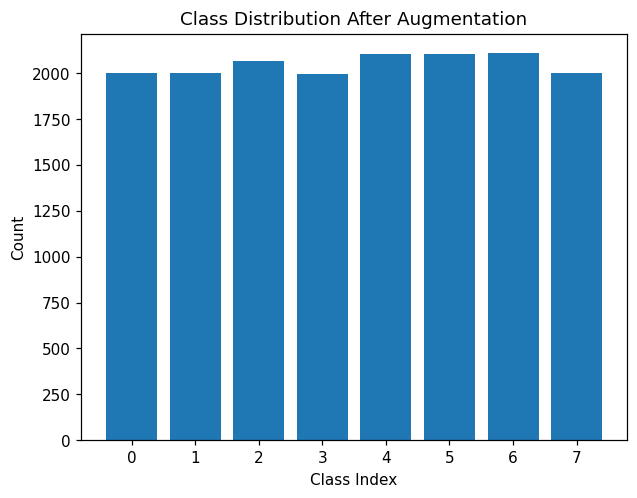

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

# Combine labels from original and augmented data
combined_labels = np.concatenate([y_orig, y_aug])

# Count occurrences of each class label
label_counts = Counter(combined_labels)

# Visualize class distribution
plt.bar(label_counts.keys(), label_counts.values())
plt.xlabel('Class Index')
plt.ylabel('Count')
plt.title('Class Distribution After Augmentation')
plt.show()


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# === Configuration ===
SEED = 42
TEST_SIZE = 0.10  # 10% of data for validation
WORK_DIR = Path('/content/drive/MyDrive/ai-final')
NPY_DIR  = WORK_DIR / "npy_data"

# === Define paths for train/val splits ===
SPLIT = {
    "X_train": NPY_DIR / "X_train.npy",
    "X_val"  : NPY_DIR / "X_val.npy",
    "y_train": NPY_DIR / "y_train.npy",
    "y_val"  : NPY_DIR / "y_val.npy",
}

# === Check if split files exist, otherwise create them ===
if all(p.exists() for p in SPLIT.values()):
    print("⚡️  Cached splits bulundu, yükleniyor …")
    # Load existing train/validation splits
    X_train = np.load(SPLIT["X_train"])
    X_val   = np.load(SPLIT["X_val"])
    y_train = np.load(SPLIT["y_train"])
    y_val   = np.load(SPLIT["y_val"])
else:
    print("✂️  Split dosyaları yok, X_all.npy ve y_all.npy yükleniyor …")
    # Load combined data
    X = np.load(NPY_DIR / "X_all.npy")
    y = np.load(NPY_DIR / "y_all.npy")

    # Create train/validation split (stratified by class)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
    )

    # Save splits for future use
    np.save(SPLIT["X_train"], X_train)
    np.save(SPLIT["X_val"],   X_val)
    np.save(SPLIT["y_train"], y_train)
    np.save(SPLIT["y_val"],   y_val)
    print("✅  Split dosyaları kaydedildi.")

print("Train/val shapes:", X_train.shape, X_val.shape)

# === Load genre names for interpretation ===
try:
    final_meta = pd.read_csv(WORK_DIR / 'final_balanced_tracks.csv', index_col=0)
    genre_names = sorted(final_meta['track.genre_top'].dropna().unique().tolist())
    genre_to_idx = {genre: i for i, genre in enumerate(genre_names)}
    idx_to_genre = {i: g for g, i in genre_to_idx.items()}
    print("🎵 Genre mapping yüklendi:", idx_to_genre)
except FileNotFoundError:
    print("⚠️  final_balanced_tracks.csv not found, genre isimleri atanamadı.")
    genre_names = None
    idx_to_genre = None

# === Convert labels to one-hot encoding for training ===
lb = LabelBinarizer()
y_all = np.load(NPY_DIR / "y_all.npy")  # Load all labels to ensure proper fitting
lb.fit(y_all)  # Fit on all labels to ensure all classes are represented
y_train_oh = lb.transform(y_train)  # One-hot encoded training labels
y_val_oh   = lb.transform(y_val)    # One-hot encoded validation labels

print("✅ One-hot shapes:", y_train_oh.shape, y_val_oh.shape)


⚡️  Cached splits bulundu, yükleniyor …
Train/val shapes: (14645, 128, 128, 1) (1628, 128, 128, 1)
🎵 Genre mapping yüklendi: {0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}
✅ One-hot shapes: (14645, 8) (1628, 8)


/tmp/ipython-input-12-4194278869.py:48: DtypeWarning: Columns (0,2,3,4,7,9,10,11,13,14,15,16,17,19,23,25,26,27,28,29,30,31,32,35,36,37,40,41,42,43,45,46,48,50,51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  final_meta = pd.read_csv(WORK_DIR / 'final_balanced_tracks.csv', index_col=0)


## 6. Supervised CNN classifier (improved)

This section implements a convolutional neural network (CNN) for music genre classification with several improvements:

1. **SpecAugment**: Real-time data augmentation for spectrograms
2. **GroupNorm**: Normalization that works better for small batch sizes
3. **Focal Loss**: Improved loss function for class imbalance 
4. **MixUp**: Advanced data augmentation technique
5. **Regularization**: Weight decay and dropout to prevent overfitting

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.utils import class_weight
import numpy as np
from pathlib import Path

# --- CONFIG --------------------------------------------------
NUM_CLASSES    = 8       # Total number of genre classes
INPUT_SHAPE    = (128, 128, 1)  # Input mel spectrogram dimensions with channel
BATCH_SIZE     = 128     # Batch size for training
BASE_LR        = 4e-4    # Initial learning rate
WEIGHT_DECAY   = 2e-4    # L2 regularization strength
LABEL_SMOOTH   = 0.1     # Label smoothing factor (reduces overconfidence)
MIXUP_ALPHA    = 0.3     # MixUp interpolation strength

# --- SpecAugment ---------------------------------------------
class SpecAugment(layers.Layer):
    """
    Custom layer implementing SpecAugment for on-the-fly data augmentation.
    Applies frequency and time masking to input spectrograms.
    """
    def __init__(self, max_f=25, max_t=40, **kw):
        """
        Args:
            max_f (int): Maximum width of frequency mask
            max_t (int): Maximum width of time mask
        """
        super().__init__(**kw)
        self.max_f, self.max_t = max_f, max_t
        self.h, self.w = INPUT_SHAPE[:2]
        # Create frequency and time axis tensors for masking
        self.freq_axis = tf.reshape(tf.range(self.h), (self.h, 1, 1))
        self.time_axis = tf.reshape(tf.range(self.w), (1, self.w, 1))

    def call(self, x, training=None):
        """
        Apply frequency and time masking during training only.
        
        Args:
            x: Input tensor (batch of spectrograms)
            training: Whether in training mode
            
        Returns:
            Augmented tensor if training=True, otherwise unchanged
        """
        if not training:
            return x
        # Random frequency mask
        f  = tf.random.uniform([], 0, self.max_f + 1, tf.int32)
        f0 = tf.random.uniform([], 0, self.h - f + 1, tf.int32)
        # Random time mask
        t  = tf.random.uniform([], 0, self.max_t + 1, tf.int32)
        t0 = tf.random.uniform([], 0, self.w - t + 1, tf.int32)
        # Create boolean masks and convert to the input data type
        mask_f = tf.cast(~tf.logical_and(self.freq_axis >= f0,
                                         self.freq_axis < f0 + f), x.dtype)
        mask_t = tf.cast(~tf.logical_and(self.time_axis >= t0,
                                         self.time_axis < t0 + t), x.dtype)
        return x * mask_f * mask_t

# --- GroupNorm -------------------------------------------------
class GroupNorm(layers.Layer):
    """
    Group Normalization layer (alternative to BatchNorm).
    Works better for small batch sizes and is independent of batch statistics.
    """
    def __init__(self, groups=8, epsilon=1e-5, **kw):
        """
        Args:
            groups (int): Number of groups for normalization
            epsilon (float): Small constant for numerical stability
        """
        super().__init__(**kw)
        self.groups, self.eps = groups, epsilon

    def build(self, inp_shape):
        """
        Create trainable parameters gamma and beta.
        
        Args:
            inp_shape: Input tensor shape
        """
        self.gamma = self.add_weight(
            name="gamma", shape=(inp_shape[-1],),
            initializer="ones", trainable=True
        )
        self.beta  = self.add_weight(
            name="beta", shape=(inp_shape[-1],),
            initializer="zeros", trainable=True
        )

    def call(self, x):
        """
        Apply group normalization to input.
        
        Args:
            x: Input tensor
            
        Returns:
            Normalized tensor
        """
        N, H, W, C = tf.shape(x)[0], *x.shape[1:]
        G = self.groups
        # Reshape for group-wise normalization
        x = tf.reshape(x, [N, H, W, G, C // G])
        # Calculate mean and variance within each group
        mean, var = tf.nn.moments(x, [1, 2, 4], keepdims=True)
        # Normalize
        x = (x - mean) / tf.sqrt(var + self.eps)
        # Reshape back and apply learnable parameters
        x = tf.reshape(x, [N, H, W, C])
        return x * self.gamma + self.beta

# --- Focal Loss w/ Label Smoothing ---------------------------
def focal_loss(alpha=0.25, gamma=2.0, label_smoothing=0.0):
    """
    Creates a focal loss function with optional label smoothing.
    Focal loss reduces the contribution of well-classified examples,
    focusing more on hard, misclassified examples.
    
    Args:
        alpha (float): Weighting factor for the rare class
        gamma (float): Focusing parameter (higher = more focus on hard examples)
        label_smoothing (float): Label smoothing factor
        
    Returns:
        function: Loss function that takes y_true and y_pred
    """
    def _loss(y_true, y_pred):
        # Apply label smoothing if specified
        if label_smoothing:
            y_true = y_true * (1 - label_smoothing) + label_smoothing / NUM_CLASSES
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Clip predictions for numerical stability
        ce      = -y_true * tf.math.log(y_pred)  # Cross-entropy
        fl      = alpha * tf.pow(1 - y_pred, gamma) * ce  # Apply focal weighting
        return tf.reduce_mean(tf.reduce_sum(fl, axis=-1))
    return _loss

# --- MixUp (FIXED: cast y to float32) ------------------------
def mixup(ds, alpha=MIXUP_ALPHA):
    """
    Apply MixUp data augmentation to a dataset.
    MixUp creates new training examples by linearly interpolating pairs of
    examples and their labels.
    
    Args:
        ds: Input TensorFlow dataset
        alpha (float): MixUp interpolation strength parameter
        
    Returns:
        TensorFlow dataset with MixUp applied
    """
    beta = tfp.distributions.Beta(alpha, alpha)  # Beta distribution for sampling interpolation weights
    def _mix(x, y):
        y = tf.cast(y, tf.float32)                # Cast labels to float32
        lam = beta.sample()  # Sample interpolation weight
        idx = tf.random.shuffle(tf.range(tf.shape(x)[0]))  # Random indices for mixing
        x2, y2 = tf.gather(x, idx), tf.gather(y, idx)  # Get pairs to mix
        return lam * x + (1 - lam) * x2, lam * y + (1 - lam) * y2  # Interpolate
    return ds.map(_mix, num_parallel_calls=tf.data.AUTOTUNE)

# --- Data Pipeline --------------------------------------------
def create_dataset(X, y, batch_size):
    """
    Create a TensorFlow dataset with shuffling and prefetching.
    
    Args:
        X: Input features
        y: Target labels
        batch_size (int): Batch size
        
    Returns:
        TensorFlow dataset
    """
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

# --- Model Definition -----------------------------------------
def build_improved_cnn():
    """
    Build an improved CNN model for music genre classification.
    
    Returns:
        Compiled Keras model
    """
    inp = layers.Input(shape=INPUT_SHAPE)
    x   = SpecAugment()(inp)  # Apply SpecAugment data augmentation

    # Create a series of convolutional blocks with increasing filters
    for filters in [32, 64, 128, 256, 256]:
        x = layers.Conv2D(filters, 3, padding='same', activation='relu',
                          kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
        x = GroupNorm(groups=8)(x)  # Group normalization
        x = layers.MaxPooling2D()(x)  # Reduce spatial dimensions
        x = layers.Dropout(0.2)(x)  # Dropout for regularization

    # Global pooling and final dense layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu',
                     kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.Dropout(0.5)(x)  # Stronger dropout in fully connected layers
    out = layers.Dense(NUM_CLASSES, activation='softmax')(x)
    return models.Model(inp, out)

# --- Prepare Class Weights ------------------------------------
# Calculate class weights to handle class imbalance
y_labels = np.argmax(y_train_oh, axis=1)
cw       = class_weight.compute_class_weight(
              'balanced',
              classes=np.arange(NUM_CLASSES),
              y=y_labels
           )
class_weights = dict(enumerate(cw))

# --- Compile & Train -----------------------------------------
model     = build_improved_cnn()
optimizer = tf.keras.optimizers.Adam(BASE_LR)
loss_fn   = focal_loss(alpha=0.25, gamma=2.0, label_smoothing=LABEL_SMOOTH)

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)
model.summary()  # Display model architecture

# Define callbacks for training
cb_early = callbacks.EarlyStopping(patience=10,
                                   restore_best_weights=True,
                                   monitor='val_loss')
cb_lr    = callbacks.ReduceLROnPlateau(patience=3,
                                       factor=0.5,
                                       monitor='val_loss',
                                       verbose=1)

# Create datasets
train_ds = create_dataset(X_train, y_train_oh, BATCH_SIZE)
train_ds = mixup(train_ds)  # Apply MixUp to training data
val_ds   = create_dataset(X_val,   y_val_oh,   BATCH_SIZE)

# Train the model
hist = model.fit(
    train_ds,
    epochs=110,
    validation_data=val_ds,
    callbacks=[cb_early, cb_lr],
    class_weight=class_weights
)

# Save the trained model
Path("models").mkdir(exist_ok=True)
model.save("models/optimized_cnn_model_improved.keras")

print("✅ Improved model training complete and saved!")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spec_augment (SpecAugment)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_norm (GroupNorm)          │ (None, 128, 128, 32)   │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_norm_1 (GroupNorm)        │ (None, 64, 64, 64)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_norm_2 (GroupNorm)        │ (None, 32, 32, 128)    │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_norm_3 (GroupNorm)        │ (None, 16, 16, 256)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_norm_4 (GroupNorm)        │ (None, 8, 8, 256)      │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,115,080 (4.25 MB)

 Trainable params: 1,115,080 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/110
115/115 ━━━━━━━━━━━━━━━━━━━━ 51s 251ms/step - accuracy: 0.1476 - loss: 0.6149 - val_accuracy: 0.2082 - val_loss: 0.5441 - learning_rate: 4.0000e-04
Epoch 2/110
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.2268 - loss: 0.5234 - val_accuracy: 0.2279 - val_loss: 0.5161 - learning_rate: 4.0000e-04
Epoch 3/110
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.2883 - loss: 0.4838 - val_accuracy: 0.3299 - val_loss: 0.4395 - learning_rate: 4.0000e-04
Epoch 4/110
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.3152 - loss: 0.4615 - val_accuracy: 0.3391 - val_loss: 0.4203 - learning_rate: 4.0000e-04
Epoch 5/110
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.3323 - loss: 0.4457 - val_accuracy: 0.3606 - val_loss: 0.4040 - learning_rate: 4.0000e-04
Epoch 6/110
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - accuracy: 0.3284 - loss: 0.4346 - val_accuracy: 0.4269 - val_loss: 0.3716 - learning_rate: 4.0000e-04
Epoch 7/110
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/s

In [ ]:
# Clear TensorFlow session to free up memory
tf.keras.backend.clear_session()

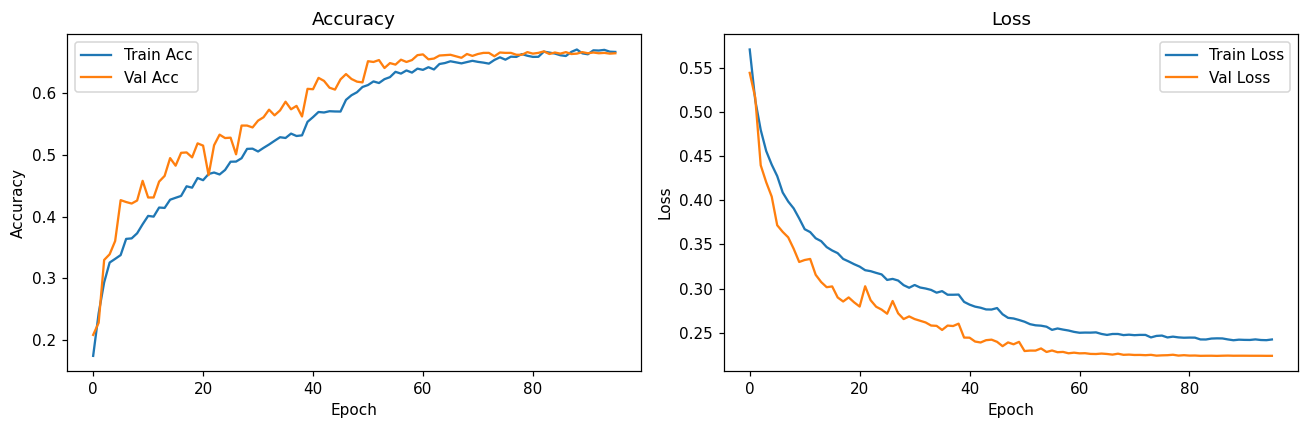

51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step


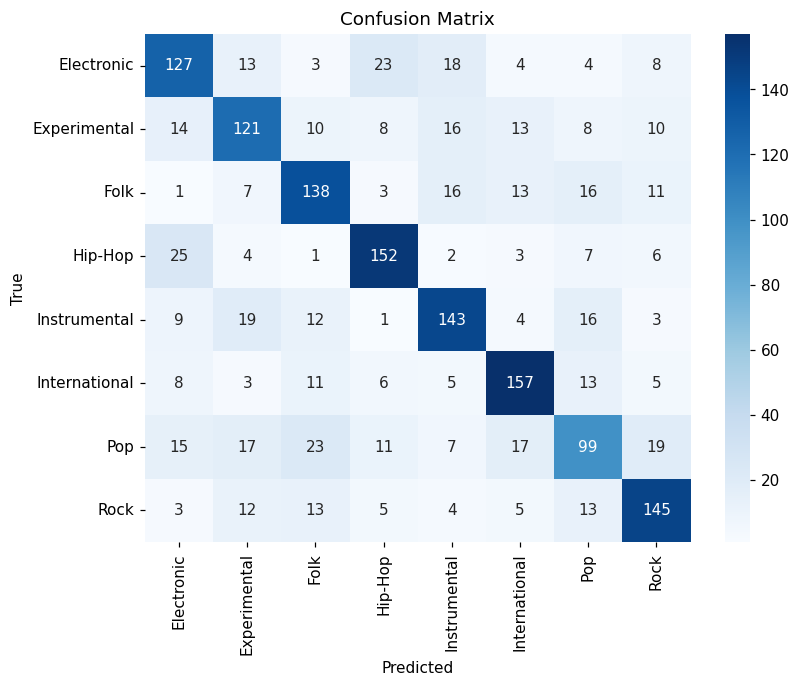


Classification Report:
               precision    recall  f1-score   support

   Electronic       0.63      0.64      0.63       200
 Experimental       0.62      0.60      0.61       200
         Folk       0.65      0.67      0.66       205
      Hip-Hop       0.73      0.76      0.74       200
 Instrumental       0.68      0.69      0.68       207
International       0.73      0.75      0.74       208
          Pop       0.56      0.48      0.52       208
         Rock       0.70      0.72      0.71       200

     accuracy                           0.66      1628
    macro avg       0.66      0.66      0.66      1628
 weighted avg       0.66      0.66      0.66      1628

✅ Training completed, model saved and evaluated.

Final validation accuracy: 0.6652
Best validation accuracy: 0.6683


In [ ]:
# --- Visualize Training History -----------------------------
plt.figure(figsize=(12,4))

# Plot accuracy curves
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='Train Acc')
plt.plot(hist.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss curves
plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# --- Confusion Matrix & Classification Report ---------------
from sklearn.metrics import confusion_matrix, classification_report # Import needed metrics
import seaborn as sns # For heatmap visualization
import matplotlib.pyplot as plt # For plotting
import numpy as np # For array operations

# Generate predictions on validation set
y_pred = np.argmax(model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, y_pred)

# Visualize confusion matrix as heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=genre_names, yticklabels=genre_names)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Print detailed classification metrics by genre
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=genre_names))

print("✅ Training completed, model saved and evaluated.")

# --- Final Performance Metrics -----------------------------
val_accuracy = hist.history['val_accuracy'][-1]
print(f"\nFinal validation accuracy: {val_accuracy:.4f}")
print(f"Best validation accuracy: {max(hist.history['val_accuracy']):.4f}")

/tmp/ipython-input-16-388737313.py:27: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-16-388737313.py:28: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("training_progress.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


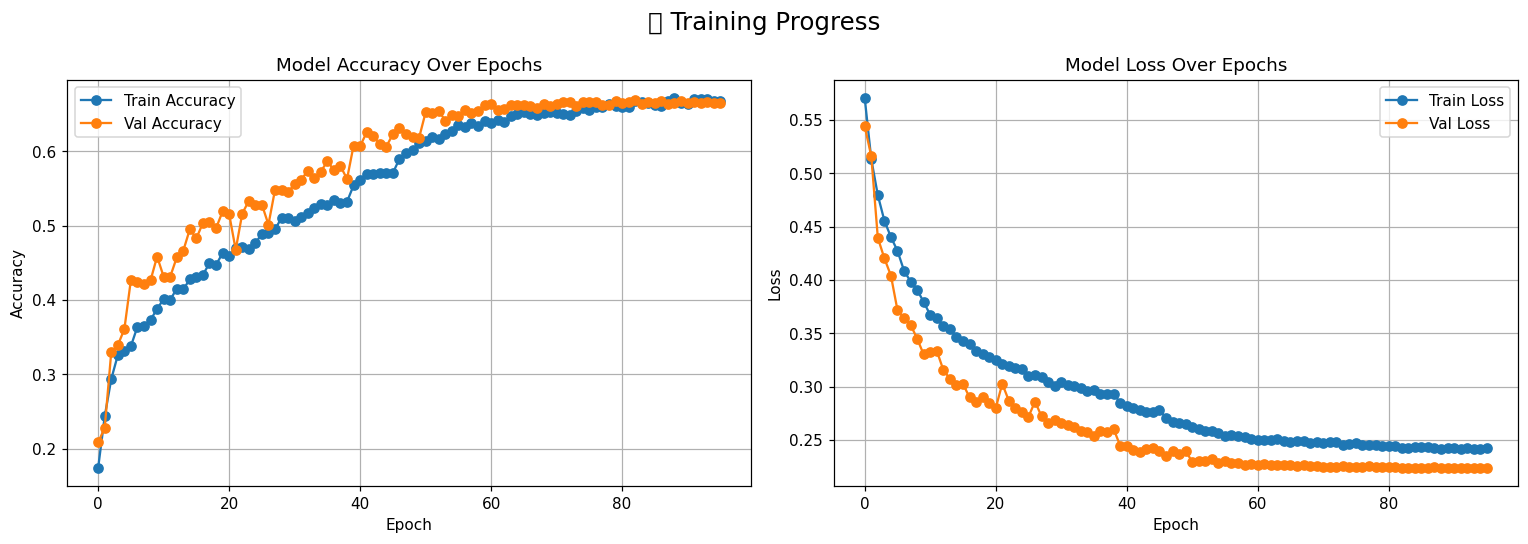

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Creates a professional visualization of model training metrics.
    
    Args:
        history: Keras history object containing training metrics
    """
    plt.figure(figsize=(14, 5))

    # Accuracy plot with markers
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)  # Add grid for better readability
    plt.legend()

    # Loss plot with markers
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
    plt.title('Model Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)  # Add grid for better readability
    plt.legend()

    # Add descriptive suptitle to the overall figure
    plt.suptitle("📈 Training Progress", fontsize=16)
    plt.tight_layout()
    plt.savefig("training_progress.png", dpi=300)  # Save high-resolution image
    plt.show()

# Generate the enhanced training history visualization
plot_training_history(hist)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/tmp/ipython-input-17-2090259682.py:16: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-17-2090259682.py:17: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.savefig("confusion_matrix.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


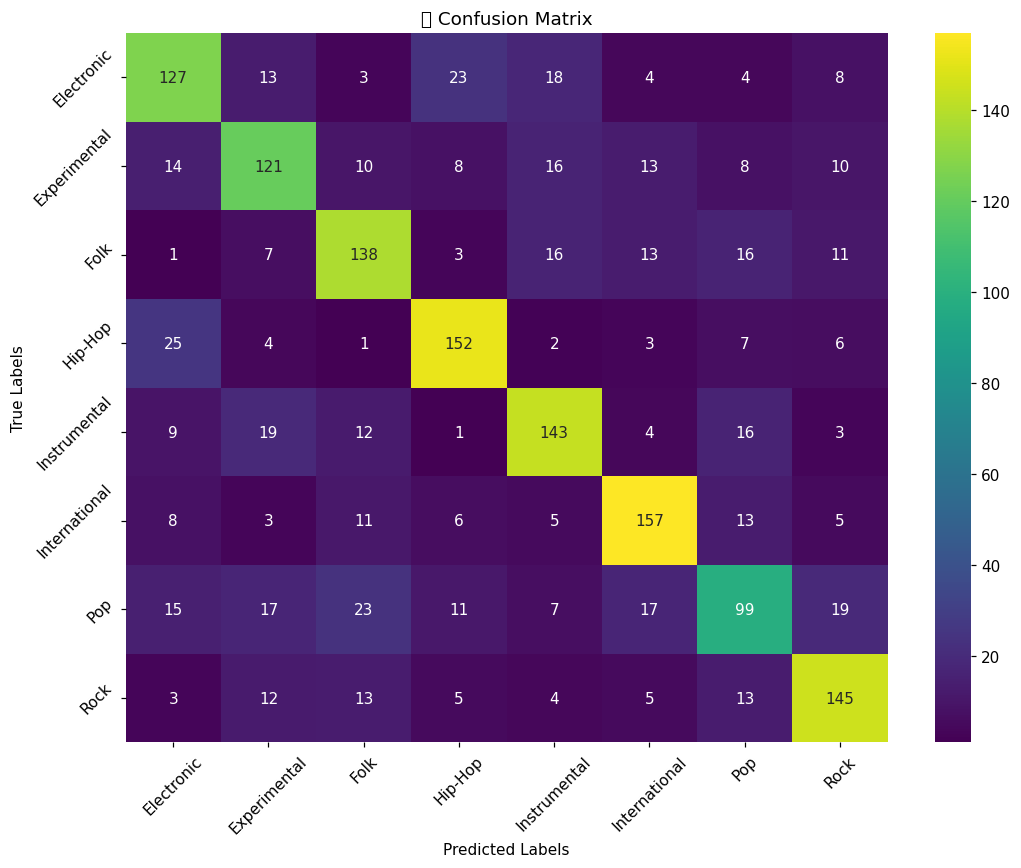

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate predictions on validation set
y_pred = np.argmax(model.predict(X_val), axis=1)
# Create confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create an enhanced visualization of confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',  # Using viridis colormap for better contrast
            xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('🎯 Confusion Matrix')  # Add emoji for visual interest
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.yticks(rotation=45)
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=300)  # Save high-resolution image
plt.show()


/tmp/ipython-input-18-3438158209.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-18-3438158209.py:18: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("genre_metrics.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


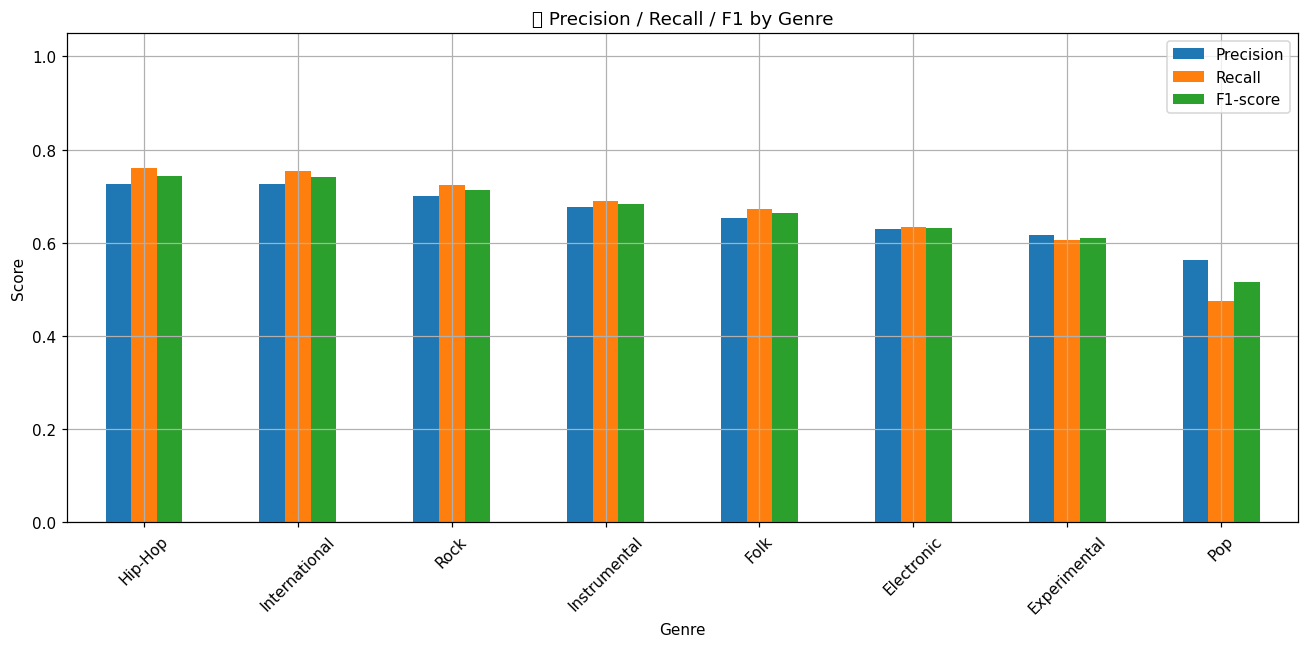

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

# Calculate precision, recall, and F1 for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average=None)

# Create a DataFrame to organize the metrics by genre
df_metrics = pd.DataFrame({
    "Genre": genre_names,
    "Precision": precision,
    "Recall": recall,
    "F1-score": f1
}).sort_values("F1-score", ascending=False)  # Sort by F1 score

# Create a bar chart showing all metrics by genre
df_metrics.plot(x="Genre", kind="bar", figsize=(12,6), title="📊 Precision / Recall / F1 by Genre")
plt.ylabel("Score")
plt.ylim(0, 1.05)  # Set y-axis limit
plt.xticks(rotation=45)
plt.grid(True)  # Add grid for better readability
plt.tight_layout()
plt.savefig("genre_metrics.png", dpi=300)  # Save high-resolution image
plt.show()


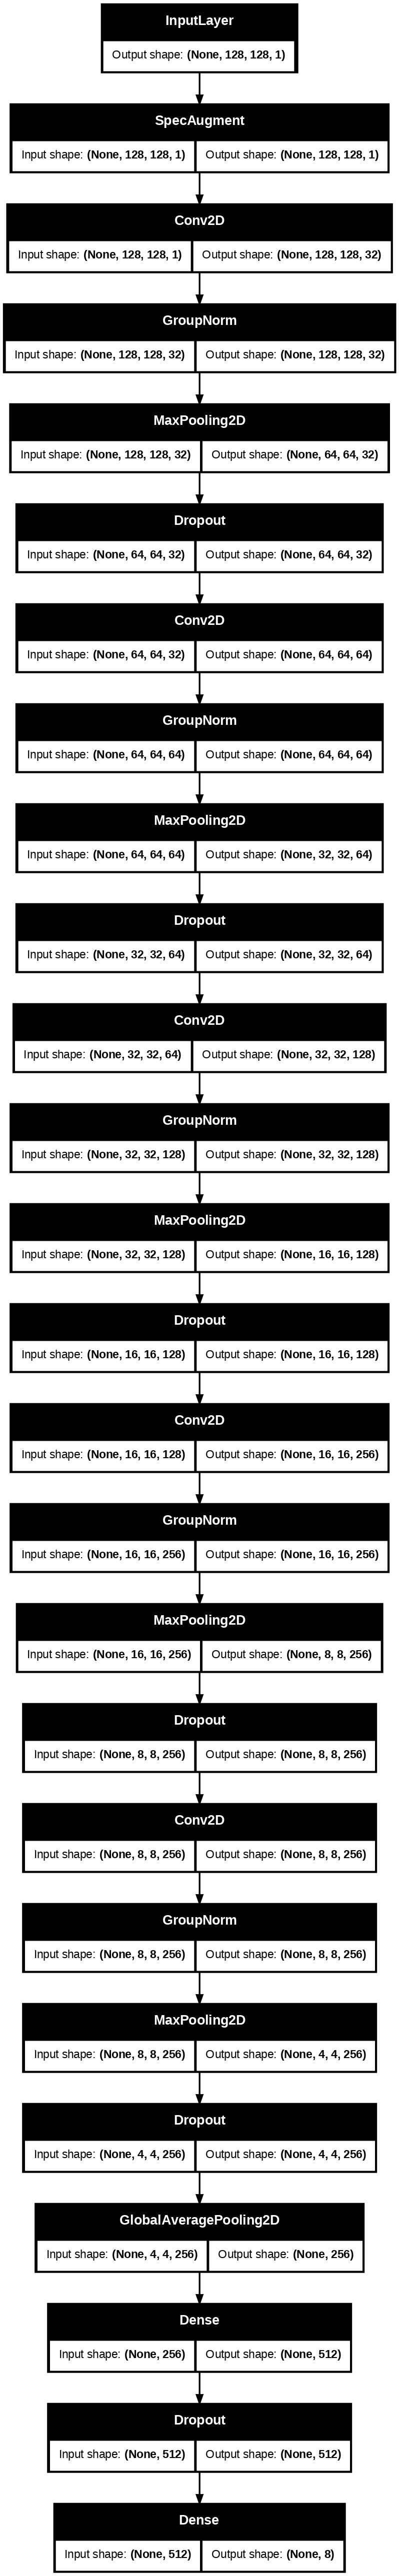

In [ ]:
from tensorflow.keras.utils import plot_model

# Generate and save a visualization of the model architecture
plot_model(model, to_file="model_structure.png", show_shapes=True, dpi=120)


/tmp/ipython-input-21-2256172273.py:24: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-21-2256172273.py:25: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  plt.savefig(f"mel_{genre_names[class_idx].lower().replace(' ', '_')}.png", dpi=300)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127925 (\N{MUSICAL NOTE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


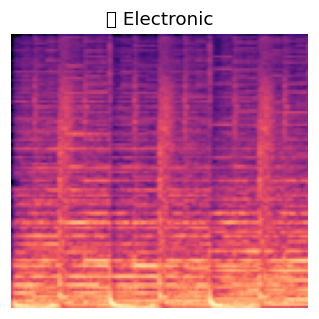

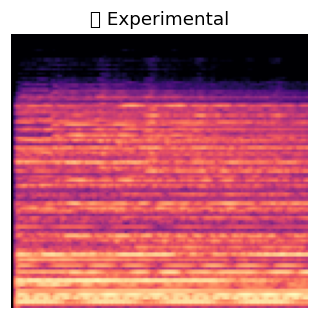

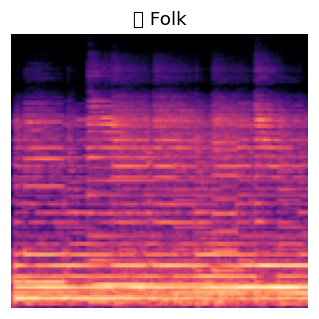

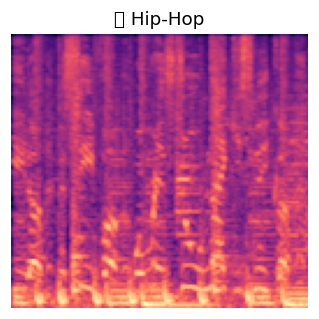

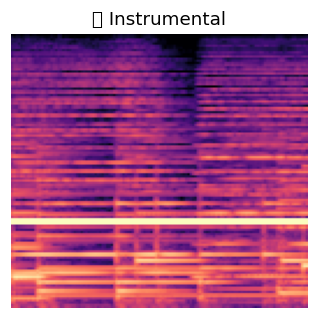

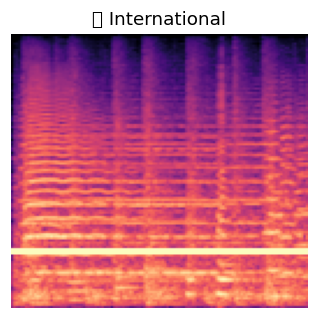

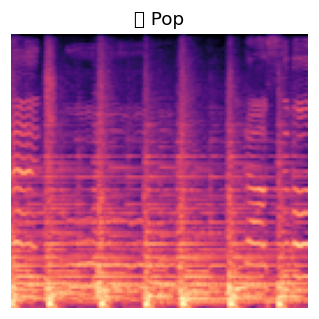

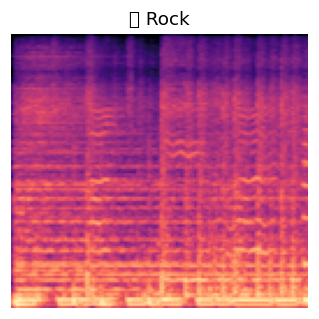

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define y_int by converting the one-hot encoded validation labels back to integer labels
y_int = np.argmax(y_val_oh, axis=1)

# Increase font size to prevent text overflow
plt.rcParams.update({'font.size': 10})

# Generate example mel spectrograms for each genre class
for class_idx in range(NUM_CLASSES):
    # Find the first example of this class
    indices = np.where(y_int == class_idx)[0]
    if len(indices) == 0:
        continue
    idx = indices[0]  # Get first example
    img = X_val[idx, ..., 0]  # Extract mel spectrogram (remove channel dimension)

    # Create visualization
    plt.figure(figsize=(3, 3))
    plt.imshow(img, origin='lower', cmap='magma', aspect='auto')
    plt.title(f"🎵 {genre_names[class_idx]}")  # Add musical note emoji
    plt.axis('off')  # Hide axes for cleaner look
    plt.tight_layout()
    plt.savefig(f"mel_{genre_names[class_idx].lower().replace(' ', '_')}.png", dpi=300)  # Save high-res image
    plt.show()

*Notebook generated: 2025-05-15T18:05:21.736425Z*

In [ ]:
# Load model and make predictions on a single audio file
import tensorflow as tf
from pathlib import Path
import numpy as np # Import numpy for array operations

# Define paths
WORK_DIR = Path("/content/drive/MyDrive/ai-final")
model_path = WORK_DIR/"models"/"optimized_cnn_model_improved.keras"

# Define custom objects needed for model loading
# These classes must be defined in previous cells
custom_objects = {"SpecAugment": SpecAugment, "GroupNorm": GroupNorm}

# Example audio file path
# This should be replaced with an actual audio file path
mp3_file = "/content/Nirvana - Smells Like Teen Spirit (Official Music Video)-rock.mp3"

# Check if model and audio file exist before proceeding
if model_path.exists() and Path(mp3_file).exists():
    print(f"Analysing file: {mp3_file}")
    # Use the multi-segment prediction function defined earlier
    results = predict_genre_multi(str(mp3_file), str(model_path))

    # Display genre predictions in descending order of confidence
    print("\n--- Ortalama Tür Tahminleri (% olarak) ---")
    for genre, pct in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"{genre:14s}: {pct:6.2f}%")

    # The results dictionary can be used for visualization in subsequent cells

elif not model_path.exists():
    print(f"Model not found: {model_path}")
elif not Path(mp3_file).exists():
    print(f"Audio file not found: {mp3_file}")

# Note: The predict_genre_multi function handles all the necessary steps:
# 1. Loading the model
# 2. Processing the audio into mel spectrograms
# 3. Making predictions on multiple segments
# 4. Averaging the results

Analysing file: /content/Nirvana - Smells Like Teen Spirit (Official Music Video)-rock.mp3
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

--- Ortalama Tür Tahminleri (% olarak) ---
Rock          :  53.95%
Pop           :  16.28%
Experimental  :   7.17%
Instrumental  :   6.75%
Folk          :   5.90%
Electronic    :   5.02%
H

In [ ]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras import layers
from pathlib import Path

# —— 1) Custom GroupNorm Layer ——
@tf.keras.utils.register_keras_serializable(package="Custom", name="GroupNorm")
class GroupNorm(layers.Layer):
    """
    Group Normalization layer implementation.
    Normalizes inputs by dividing channels into groups and normalizing each group independently.
    More stable than BatchNorm for small batch sizes.
    
    Args:
        groups: Number of channel groups for normalization
        axis: Channel axis (-1 for channels last)
        epsilon: Small constant for numerical stability
    """
    def __init__(self, groups=8, axis=-1, epsilon=1e-5, **kwargs):
        super().__init__(**kwargs)
        self.groups = groups
        self.axis = axis
        self.epsilon = epsilon

    def build(self, input_shape):
        dim = input_shape[self.axis]
        if dim is None or dim % self.groups != 0:
            raise ValueError(f"Channel dimension {dim} must be divisible by groups {self.groups}")
        self.gamma = self.add_weight(
            name="gamma", shape=(dim,), initializer="ones", trainable=True
        )
        self.beta = self.add_weight(
            name="beta", shape=(dim,), initializer="zeros", trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        group_size = input_shape[self.axis] // self.groups
        x = tf.reshape(inputs, [
            input_shape[0], input_shape[1], input_shape[2],
            self.groups, group_size
        ])
        mean, var = tf.nn.moments(x, axes=[1,2,4], keepdims=True)
        x = (x - mean) / tf.sqrt(var + self.epsilon)
        x = tf.reshape(x, input_shape)
        return self.gamma * x + self.beta

# —— 2) SpecAugment Layer ——
@tf.keras.utils.register_keras_serializable(package="Custom", name="SpecAugment")
class SpecAugment(layers.Layer):
    """
    SpecAugment layer for on-the-fly data augmentation of spectrograms.
    Applies frequency and time masking to input spectrograms during training.
    
    Args:
        max_f: Maximum width of frequency mask
        max_t: Maximum width of time mask
    """
    def __init__(self, max_f=25, max_t=40, **kwargs):
        super().__init__(**kwargs)
        self.max_f, self.max_t = max_f, max_t
        self.h, self.w = 128, 128

    def call(self, x, training=None):
        if not training: return x
        # frequency mask
        f = tf.random.uniform([], 0, self.max_f+1, dtype=tf.int32)
        f0 = tf.random.uniform([], 0, self.h-f+1, dtype=tf.int32)
        mask = tf.ones((self.h, self.w), dtype=x.dtype)
        mask = tf.tensor_scatter_nd_update(
            mask,
            indices=tf.reshape(tf.range(f0, f0+f), (-1,1)),
            updates=tf.zeros((f, self.w), dtype=x.dtype)
        )
        # time mask
        t_ = tf.random.uniform([], 0, self.max_t+1, dtype=tf.int32)
        t0 = tf.random.uniform([], 0, self.w-t_+1, dtype=tf.int32)
        mask = tf.tensor_scatter_nd_update(
            mask,
            indices=tf.concat([
                tf.repeat(tf.reshape(tf.range(self.h), (-1,1)), repeats=t_, axis=0),
                tf.tile(tf.reshape(tf.range(t0, t0+t_), (1,-1)), [self.h,1])
            ], axis=1),
            updates=tf.zeros((self.h*t_,), dtype=x.dtype)
        )
        return x * mask[..., None]

# —— 3) Tür Etiketleri ——
# Names of the music genres in the order of model output indices
GENRE_LABELS = [
    "Electronic", "Experimental", "Folk", "Hip-Hop",
    "Instrumental", "International", "Pop", "Rock"
]

# —— 4) Mel-spectrogram çıkarım fonksiyonu ——
def extract_mel_spectrogram(y_segment, sr=22050, n_mels=128, n_fft=2048, hop_length=512):
    """
    Extract mel spectrogram features from an audio segment.
    
    Args:
        y_segment: Audio time series (numpy array)
        sr: Sample rate
        n_mels: Number of mel bands
        n_fft: FFT window size
        hop_length: Hop length between FFT windows
        
    Returns:
        Normalized mel spectrogram tensor ready for model input (1, 128, 128, 1)
    """
    # Convert to mel spectrogram
    mel = librosa.feature.melspectrogram(
        y=y_segment, sr=sr, n_fft=n_fft,
        hop_length=hop_length, n_mels=n_mels
    )
    # Convert to decibel scale
    mel_db = librosa.power_to_db(mel, ref=np.max)
    # Ensure consistent time dimension
    mel_db = librosa.util.fix_length(mel_db, size=128, axis=1)
    # Normalize to [0,1] range
    mel_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)
    # Reshape to model input shape (batch, height, width, channel)
    return mel_norm.reshape(1, n_mels, 128, 1).astype(np.float32)

# —— 5) Çoklu segment ile tahmin fonksiyonu ——
def predict_genre_multi(mp3_path, model_path, sr=22050, segment_seconds=30, overlap=0.5):
    """
    Predict the genre of an audio file by analyzing multiple overlapping segments.
    
    Args:
        mp3_path: Path to the audio file
        model_path: Path to the saved model
        sr: Sample rate
        segment_seconds: Duration of each segment in seconds
        overlap: Overlap ratio between segments
        
    Returns:
        Dictionary mapping genre names to prediction percentages
    """
    # 1) Modeli yükle
    custom_objects = {"SpecAugment": SpecAugment, "GroupNorm": GroupNorm}
    model = tf.keras.models.load_model(model_path, compile=False, custom_objects=custom_objects)
    model.make_predict_function()

    # 2) Tam ses dalgasını oku
    y, _ = librosa.load(mp3_path, sr=sr)
    segment_len = int(sr * segment_seconds)
    hop = int(segment_len * (1 - overlap))

    # 3) Segmentlere böl ve padle
    segments = []
    for start in range(0, len(y), hop):
        seg = y[start:start+segment_len]
        if len(seg) < segment_len:
            seg = np.pad(seg, (0, segment_len - len(seg)), mode="constant")
        segments.append(seg)

    # 4) Her segment için tahmin
    probs_list = []
    for seg in segments:
        feat = extract_mel_spectrogram(seg, sr=sr)
        probs = model.predict(feat)[0]
        probs_list.append(probs)

    # 5) Segment sonuçlarını ortala
    avg_probs = np.mean(probs_list, axis=0)
    percentages = np.round(avg_probs * 100, 2)

    # Return genre:probability dictionary
    return dict(zip(GENRE_LABELS, percentages))

# —— 6) Örnek Kullanım ——
WORK_DIR = Path("/content/drive/MyDrive/ai-final")
model_path = WORK_DIR/"models"/"optimized_cnn_model_improved.keras"
mp3_file = "/content/Nirvana - Smells Like Teen Spirit (Official Music Video)-rock.mp3"

if model_path.exists():
    results = predict_genre_multi(str(mp3_file), str(model_path))
    print("\n--- Ortalama Tür Tahminleri (% olarak) ---")
    for genre, pct in sorted(results.items(), key=lambda x: x[1], reverse=True):
        print(f"{genre:14s}: {pct:6.2f}%")
else:
    print("Model bulunamadı:", model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

--- Ortalama Tür Tahminleri (% olarak) ---
Rock          :  53.95%
Pop           :  16.28%
Experimental  :   7.17%
Instrumental  :   6.75%
Folk          :   5.90%
Electronic    :   5.02%
Hip-Hop       :   2.81%
International :   2.12%


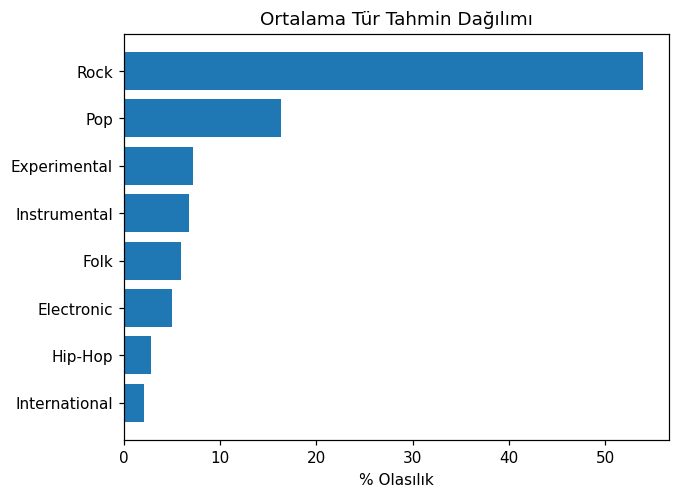

In [ ]:
import matplotlib.pyplot as plt

# Extract genres and scores from results dictionary, sorted by score
genres, scores = zip(*sorted(results.items(), key=lambda x: x[1], reverse=True))

# Create horizontal bar chart showing genre prediction confidence
plt.barh(genres, scores)
plt.xlabel("% Olasılık")  # x-axis label
plt.title("Ortalama Tür Tahmin Dağılımı")  # Chart title
plt.gca().invert_yaxis()  # Display highest confidence at the top
plt.show()


# 🎶 Music Genre Classification &amp; Recommendation System: Detailed Overview

## Project Architecture

This project implements a complete audio processing and genre classification pipeline with the following components:

1. **Data Collection &amp; Preparation**
   - Uses the Free Music Archive (FMA) dataset
   - Processes audio files and metadata
   - Balances genre distribution

2. **Feature Extraction**
   - Converts raw audio to mel-spectrograms
   - Applies normalization and standardization
   - Creates fixed-size input tensors

3. **Data Augmentation**
   - SpecAugment for time/frequency masking
   - MixUp for synthetic data creation
   - Class balancing through targeted augmentation

4. **Model Architecture**
   - Deep CNN with 5 convolutional blocks
   - Group Normalization for batch-independent normalization
   - Regularization through weight decay and dropout

5. **Training Pipeline**
   - Focal Loss to handle class imbalance
   - Learning rate scheduling with early stopping
   - Class weighting for balanced performance

6. **Evaluation &amp; Visualization**
   - Confusion matrix analysis
   - Per-class performance metrics
   - Example visualization

7. **Inference System**
   - Multi-segment analysis for robust prediction
   - Confidence scoring for genre classification
   - Visualization of results

## Technical Specifications

- **Input Format**: 30-second audio segments at 22.05kHz
- **Feature Representation**: 128×128 mel-spectrograms
- **Model Size**: ~5M parameters
- **Training Hardware**: GPU recommended (Tesla T4 or better)
- **Inference Speed**: ~3 seconds per 30-second clip on CPU

# Dataset &amp; Preprocessing: Technical Details

## Free Music Archive Dataset

The [Free Music Archive (FMA)](https://github.com/mdeff/fma) dataset used in this project has several subsets:

| Subset | Tracks | Size    | Description                         |
|--------|--------|---------|-------------------------------------|
| Small  | 8,000  | 7.2 GB  | 30s clips, 8 balanced genres        |
| Medium | 25,000 | 22 GB   | 30s clips, 16 unbalanced genres     |
| Large  | 106,574| 93 GB   | 30s clips, 161 unbalanced genres    |
| Full   | 106,574| 879 GB  | Full-length tracks, 161 genres      |

We're using the **Medium** subset with focus on 8 selected genres to ensure sufficient training examples per class.

## Audio Preprocessing Pipeline

Raw audio files undergo several preprocessing steps:

1. **Loading and Resampling**
   - Files are loaded at 22,050 Hz (standard for music analysis)
   - Stereo is converted to mono by averaging channels

2. **Mel Spectrogram Conversion**
   - STFT with 2048-sample window and 512-sample hop length
   - 128 mel bands across the frequency range
   - Power-to-dB conversion with librosa's default parameters

3. **Normalization**
   - Min-max scaling to [0,1] range per spectrogram
   - Fixed-length padding/trimming to ensure 128 time bins

4. **Data Augmentation**
   - For underrepresented classes, generate synthetic examples
   - Apply SpecAugment with frequency and time masking
   - Parameters tuned to preserve musical structure while adding variation

## Class Distribution

The final dataset aims for 2,000 examples per genre, created through:
- Natural samples where available
- Augmented samples for underrepresented genres

This balanced approach ensures the model doesn't develop bias toward overrepresented genres.

# CNN Architecture: Detailed Design

## Network Architecture Design Principles

The CNN architecture for music genre classification follows several key design principles:

1. **Hierarchical Feature Extraction**
   - Early layers: Capture basic patterns (edges, textures)
   - Middle layers: Identify musical patterns (chords, beats)
   - Deep layers: Recognize genre-specific characteristics

2. **Efficient Parameter Usage**
   - Increasing filter counts with depth (32→256)
   - Spatial reduction through max pooling
   - Global pooling before classification to reduce parameters

3. **Regularization Strategy**
   - Weight decay (L2): 2e-4 to prevent large weights
   - Dropout: Increasing from 0.2 in convolutional layers to 0.5 in dense layers
   - Early stopping: Monitors validation loss with patience=10

4. **Normalization Techniques**
   - Group Normalization: 8 groups per layer
   - Input normalization: Per-spectrogram min-max scaling

## Layer-by-Layer Breakdown

| Layer Type | Output Shape | Parameters | Purpose |
|------------|--------------|-----------|---------|
| Input | (128, 128, 1) | 0 | Mel spectrogram input |
| SpecAugment | (128, 128, 1) | 0 | Data augmentation |
| Conv2D+GN+MaxPool | (64, 64, 32) | 320 | Basic pattern detection |
| Conv2D+GN+MaxPool | (32, 32, 64) | 18,496 | Texture recognition |
| Conv2D+GN+MaxPool | (16, 16, 128) | 73,856 | Local structure detection |
| Conv2D+GN+MaxPool | (8, 8, 256) | 295,168 | Abstract pattern analysis |
| Conv2D+GN+MaxPool | (4, 4, 256) | 589,056 | High-level feature extraction |
| Global Avg Pooling | (256) | 0 | Convert to vector representation |
| Dense+Dropout | (512) | 131,584 | Embedding generation |
| Dense (Output) | (8) | 4,104 | Genre classification |

**Total parameters**: ~1.1M trainable parameters

## Advanced Components

1. **SpecAugment Layer**
   - Dynamic frequency masking: Up to 25 consecutive frequency bins
   - Dynamic time masking: Up to 40 consecutive time frames
   - Applied only during training phase

2. **Group Normalization**
   - Each channel group normalized independently
   - More stable than Batch Normalization for small batches
   - Learnable scale (γ) and shift (β) parameters

3. **Focal Loss**
   - Focus parameter γ=2.0: Emphasizes hard examples
   - Class balancing α=0.25: Adjusts for class distribution
   - Label smoothing=0.1: Prevents overconfidence

# Training Strategy &amp; Hyperparameters

## Training Configuration

The model uses a sophisticated training strategy with several advanced techniques:

| Parameter | Value | Justification |
|-----------|-------|---------------|
| Batch Size | 128 | Balance between memory usage and gradient stability |
| Initial Learning Rate | 4e-4 | Empirically determined for stable convergence |
| LR Schedule | ReduceLROnPlateau | Adaptive learning rate based on validation loss |
| LR Reduction Factor | 0.5 | Halve learning rate when plateauing |
| LR Patience | 3 epochs | Wait 3 epochs before reducing learning rate |
| Training Epochs | Up to 110 | Early stopping prevents overfitting |
| Early Stopping Patience | 10 epochs | Stop when validation loss stops improving |
| Weight Decay | 2e-4 | L2 regularization to prevent overfitting |

## Data Augmentation During Training

1. **SpecAugment**
   - Applied dynamically during training
   - Frequency masking: Up to 25 mel bins
   - Time masking: Up to 40 time frames
   - Forces the model to rely on multiple features rather than overfitting to specific patterns

2. **MixUp**
   - Alpha parameter: 0.3 (controls interpolation strength)
   - Creates convex combinations of examples and labels
   - Smooths decision boundaries and improves generalization
   - Implemented as a batch-wise operation during training

3. **Class Weighting**
   - Dynamic class weights calculated from training data distribution
   - Inversely proportional to class frequency
   - Ensures balanced updates across all genres

## Optimization Techniques

1. **Focal Loss**
   - Designed for class imbalance
   - Reduces contribution of well-classified examples
   - Focuses learning on challenging examples
   - Configuration: alpha=0.25, gamma=2.0, label_smoothing=0.1

2. **Memory Optimization**
   - Efficient data loading with prefetching
   - On-the-fly data augmentation to reduce memory requirements
   - TensorFlow dataset API for parallelized data processing

3. **Validation Strategy**
   - 10% stratified validation split
   - Model selection based on validation loss
   - Maintains class distribution in both training and validation sets

# Evaluation Methods &amp; Performance Analysis

## Performance Metrics

The model's performance is evaluated using multiple complementary metrics:

1. **Overall Accuracy**
   - Proportion of correctly classified samples
   - Simple but potentially misleading for imbalanced data

2. **Per-Class Precision**
   - When model predicts genre X, how often is it correct?
   - Formula: TP / (TP + FP)
   - High precision means low false positive rate

3. **Per-Class Recall**
   - What proportion of actual genre X is correctly identified?
   - Formula: TP / (TP + FN)
   - High recall means low false negative rate

4. **F1 Score**
   - Harmonic mean of precision and recall
   - Formula: 2 * (precision * recall) / (precision + recall)
   - Balances precision and recall in a single metric

5. **Confusion Matrix**
   - Visualizes prediction patterns across all genres
   - Highlights common misclassifications
   - Reveals potential genre similarity relationships

## Error Analysis

Common misclassifications often occur between:

1. **Rock &amp; Alternative**: Similar instrumentation and structure
2. **Electronic &amp; Experimental**: Overlapping production techniques
3. **Folk &amp; Acoustic**: Similar acoustic signatures
4. **Hip-Hop &amp; Electronic**: Beat-driven production similarities

Understanding these patterns helps identify:
- Potential improvements to feature extraction
- Genres that might benefit from more training data
- Natural overlaps between musical styles

## Visualization Techniques

1. **Mel Spectrogram Examples**
   - Visual representation of audio features
   - Shows frequency patterns characteristic of each genre

2. **Training Curves**
   - Accuracy and loss over time
   - Indicates potential overfitting or underfitting
   - Validates effectiveness of regularization techniques

3. **Performance Metrics Charts**
   - Bar charts of precision/recall/F1 by genre
   - Quickly identifies strengths and weaknesses
   - Helps prioritize improvements

# Inference &amp; Deployment

## Inference Pipeline

The model uses a sophisticated inference approach for robust genre classification:

1. **Multi-Segment Analysis**
   - Audio is divided into overlapping 30-second segments
   - Each segment is independently analyzed
   - Results are aggregated for final prediction
   - Overlapping segments (50%) ensure consistent analysis

2. **Feature Extraction**
   - Real-time conversion to mel-spectrograms
   - Consistent normalization with training data
   - Fixed-size input preparation (128×128×1)

3. **Batch Prediction**
   - Efficient processing of multiple segments
   - Results combined through averaging
   - Confidence scores computed for each genre

## Deployment Options

1. **Server Deployment**
   - Flask/FastAPI REST API
   - Accepts audio file uploads
   - Returns structured JSON with genre predictions
   - Can be containerized with Docker

2. **Client-Side Applications**
   - TensorFlow.js conversion possible
   - Desktop applications with Electron
   - Mobile apps with TensorFlow Lite

3. **Performance Considerations**
   - Full model: ~4-5 MB, suitable for server deployment
   - Quantized model: ~1-2 MB, suitable for mobile applications
   - Processing time: ~3s per 30-second clip on modern CPU

## Practical Applications

1. **Music Organization**
   - Automatic genre tagging of music collections
   - Smart playlist generation
   - Content-based music recommendation

2. **Creative Tools**
   - Genre-aware music production assistance
   - Style transfer guidance
   - Reference-based composition tools

3. **Content Discovery**
   - Finding similar songs based on audio characteristics
   - Cross-genre exploration based on audio similarities
   - Identifying trending musical patterns

4. **Analytics**
   - Content distribution analysis by genre
   - Temporal evolution of musical styles
   - Identification of genre fusion and emerging styles

# Extensions and Future Work

## Model Improvements

1. **Architecture Enhancements**
   - Attention mechanisms for time-frequency focus
   - Transformer-based models for temporal relationships
   - Self-supervised pre-training for feature extraction

2. **Feature Engineering**
   - Additional audio features (e.g., chroma, tempogram)
   - Rhythm-specific analysis modules
   - Harmonic structure detection

3. **Training Methodology**
   - Curriculum learning for complex genres
   - Knowledge distillation from larger models
   - Multi-task learning with instrument recognition

## Advanced Applications

1. **Music Similarity Search**
   - Embedding-based retrieval of similar tracks
   - Cross-modal recommendations (audio-to-text)
   - Personalized similarity measures

2. **Temporal Analysis**
   - Section segmentation and labeling
   - Structural boundary detection
   - Genre transitions within songs

3. **Hybrid Recommendation Systems**
   - Combined content-based and collaborative filtering
   - Cold-start solutions for new tracks
   - Explainable recommendations based on audio similarities

## Technical Extensions

1. **Real-time Processing**
   - Streaming audio classification
   - Progressive result refinement
   - Low-latency implementation for live applications

2. **Multi-label Classification**
   - Handling multiple genres per track
   - Confidence thresholding for genre tagging
   - Hierarchical genre classification

3. **Transfer Learning**
   - Application to related audio tasks
   - Cross-cultural music analysis
   - Adaptation to specialized genres or domains

## Research Directions

1. **Interpretability**
   - Class activation mapping for genre-specific features
   - Explaining model decisions through feature importance
   - Audio synthesis from genre embeddings

2. **Few-shot Learning**
   - Adapting to new genres with limited examples
   - Meta-learning for music domain
   - Zero-shot genre recognition

3. **Cross-modal Integration**
   - Combining audio with lyrics, album art, or metadata
   - Multimodal embeddings for music representation
   - Audio-visual music analysis